In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

In [2]:
# import image
image_names = glob.glob('./camera_cal/*.jpg')

def find_corners(image_names):
	objpoints = []
	imgpoints = []
	
	objp = np.zeros((6*9, 3), np.float32)
	objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

	for idx, name in enumerate(image_names):
		img = mpimg.imread(name)
		gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
		# find corners
		ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

		if ret == True:
			print("Working on " + name)
			cv2.drawChessboardCorners(img, (9,6), corners, ret)
			new_name = "find_corner"+ str(idx) +".jpg"
			cv2.imwrite("./cornered_camera_cal/" + new_name, img)
			objpoints.append(objp)
			imgpoints.append(corners)

	return objpoints, imgpoints

# find, draw corners and save to new images
objpoints, imgpoints = find_corners(image_names)

# use a calibration image to calcualte undistort matrices
img = cv2.imread("./camera_cal/calibration16.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# save matrices to a pickled file.
undis_pickle = {'mtx': mtx, 'dist': dist}
pickle.dump(undis_pickle, open('undis_pickle.p', 'wb'))

Working on ./camera_cal\calibration10.jpg
Working on ./camera_cal\calibration11.jpg
Working on ./camera_cal\calibration12.jpg
Working on ./camera_cal\calibration13.jpg
Working on ./camera_cal\calibration14.jpg
Working on ./camera_cal\calibration15.jpg
Working on ./camera_cal\calibration16.jpg
Working on ./camera_cal\calibration17.jpg
Working on ./camera_cal\calibration18.jpg
Working on ./camera_cal\calibration19.jpg
Working on ./camera_cal\calibration2.jpg
Working on ./camera_cal\calibration20.jpg
Working on ./camera_cal\calibration3.jpg
Working on ./camera_cal\calibration6.jpg
Working on ./camera_cal\calibration7.jpg
Working on ./camera_cal\calibration8.jpg
Working on ./camera_cal\calibration9.jpg


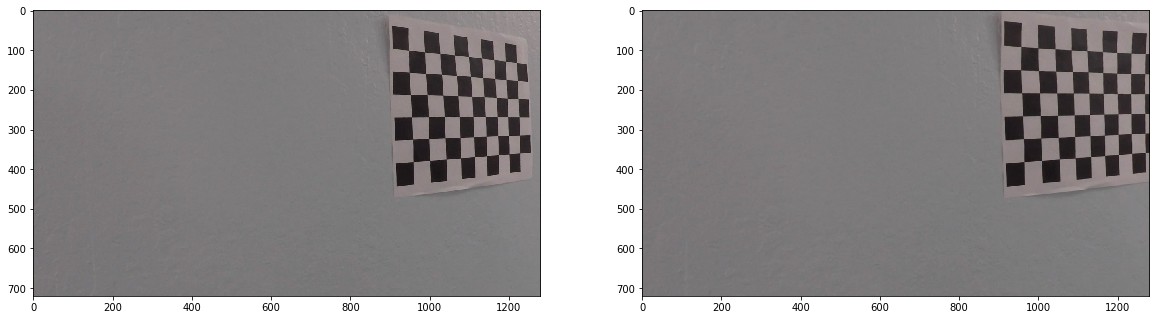

In [3]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax2.imshow(undist)
plt.show()

In [4]:
class tracker(object):
	"""docstring for tracker"""
	def __init__(self, window_width, window_height, margin, ym2pixel=1, xm2pixel=1, smooth_factor=15):

		self.centroids = []
		self.window_height = window_height
		self.window_width = window_width
		self.margin = margin
		self.ym_per_pixel = ym2pixel
		self.xm_per_pixel = xm2pixel
		self.smooth_factor = smooth_factor

	def find_window_centroids(self, img):
		window_width = self.window_width
		window_height = self.window_height
		margin = self.margin
		offset = window_width/2
		window_centroids = []
		window = np.ones(window_width)

		# find the first pair of centroids
	    # since the max value of convolution happens on the right side of the window, so the center index of the window
        # should be the index of the max convolution subtract have the the window 
		l_sum = np.sum(img[int(3*img.shape[0]/4):,:int(img.shape[1]/2)], axis=0)
		l_center = np.argmax(np.convolve(window, l_sum)) - offset
		r_sum = np.sum(img[int(3*img.shape[0]/4):,int(img.shape[1]/2):], axis=0)
		r_center = np.argmax(np.convolve(window, r_sum )) + int(img.shape[1]/2) - offset
		
		# append first pair centroids
		window_centroids.append((l_center, r_center))
        

		for level in range(1, int(img.shape[0]/window_height)):
			image_layer = np.sum(img[img.shape[0]-(level+1)*window_height:img.shape[0]-level*window_height, :], axis=0)
			conv_sig = np.convolve(window, image_layer)

			# find left controid in current layer
			l_min_index = int(max(l_center+offset-margin, 0))
			l_max_index = int(min(l_center+offset+margin, img.shape[1]))
			l_center = np.argmax(conv_sig[l_min_index:l_max_index]) + l_min_index - offset

			# find right controid in current layer
			r_min_index = int(max(r_center+offset-margin, 0))
			r_max_index = int(min(r_center+offset+margin, img.shape[1]))
			r_center = np.argmax(conv_sig[r_min_index:r_max_index]) + r_min_index - offset

			# append centroids of current layer
			window_centroids.append((l_center, r_center))

		self.centroids.append(window_centroids)
		return np.average(self.centroids[-self.smooth_factor:], axis=0)

In [5]:
# import calibration matrices
undis_pickle = pickle.load( open('undis_pickle.p', 'rb'))
mtx = undis_pickle['mtx']
dist = undis_pickle['dist']

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
	# calculate gradient in x or y direction
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1,0,  ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0,1,  ksize=sobel_kernel)
    # calculate and convert to unit8
    abs_sobel = np.absolute(sobel)
    uni = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros(img.shape)
    sobel_binary[(uni>thresh[0]) & (uni<thresh[1])] = 1
    
    return sobel_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1,0,  ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0,1,  ksize=sobel_kernel)
    grad_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    uni = np.uint8(255*grad_sobel/np.max(grad_sobel))
    sobel_binary = np.zeros(img.shape)
    sobel_binary[(uni>=mag_thresh[0]) & (uni<=mag_thresh[1])] = 1
    
    return sobel_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1,0,  ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0,1,  ksize=sobel_kernel)
    grad = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    sobel_binary = np.zeros(img.shape)
    sobel_binary[(grad>=thresh[0]) & (grad<=thresh[1])] = 1
    
    return sobel_binary

def color_threshold(img, sthresh=(0, 255), vthresh=(0,255)):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = img_hls[:,:,2]
    binary_s = np.zeros(s.shape)
    binary_s[(s >= sthresh[0]) & (s <= sthresh[1])] = 1

    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = img_hsv[:,:,2]
    binary_v = np.zeros(v.shape)
    binary_v[(v >= vthresh[0]) & (v <= vthresh[1])] = 1

    binary = np.zeros(v.shape)
    binary[(binary_v==1) & (binary_s==1)] = 1

    return binary

def window_mask(width,height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-(level)*height),max(0, int(center-width/2)):min(int(center+width/2),img_ref.shape[1])]=1
    return output

img_path = glob.glob("./test_images/test*.jpg")

processing 


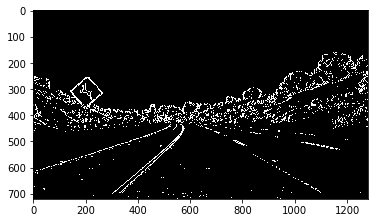

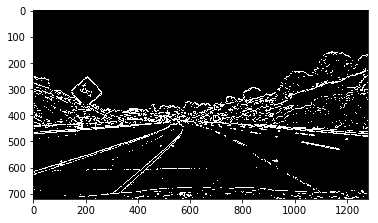

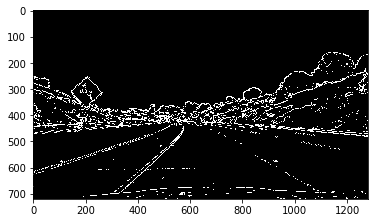

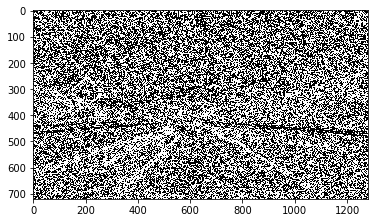

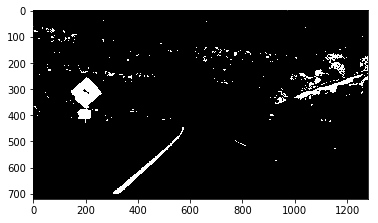

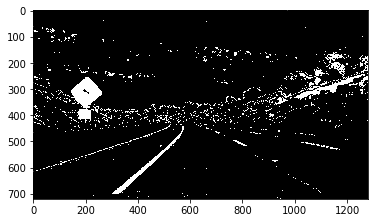

In [6]:
img = cv2.imread("./test_images/test2.jpg")
print('processing ')
img = cv2.undistort(img, mtx, dist, None, mtx)
################# This part is used for generating threshold image ###################################

# use sobel functions to find the threshold
ksize = 3 
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
plt.imshow(gradx, cmap='gray')
plt.show()

grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 255))
plt.imshow(grady, cmap='gray')
plt.show()

mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')
plt.show()

dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.6, 1.4))
plt.imshow(dir_binary, cmap='gray')
plt.show()
# convert color RGB image into HLS image and find S channel threshold
color_thresh = color_threshold(img, sthresh=(110,255), vthresh=(50, 255))
plt.imshow(color_thresh, cmap='gray')
plt.show()

# combine the sobel threshold and S channel threshold
combined_thresh = np.zeros_like(color_thresh)
# the combined positions must be assigned 255 to make it white
combined_thresh[ ((gradx==1) & (grady==1))|(color_thresh==1)] = 255
plt.imshow(combined_thresh, cmap='gray')
plt.show()

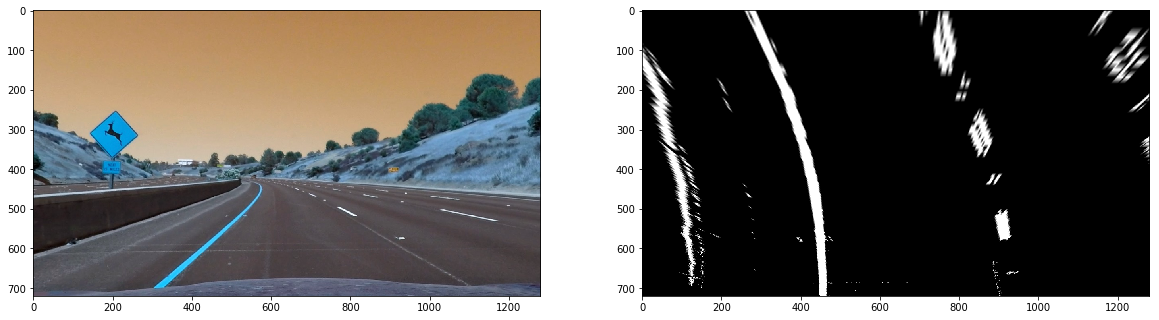

In [7]:
############### This part is used to transform perspective ########################################
# defind four source points of the image
img_size = (img.shape[1],img.shape[0])
# all widths and heights are used in percentage of the size of the image to draw a rectangular 
bot_width = 0.8
top_width = 0.091
top_height = .62
bot_height = .935
offset = img_size[0]*.25
# top_left = [570,470]
# top_right= [720,470]
# bottom_right = [1110,720]
# bottom_left = [213,720]
#src = np.float32([top_left,top_right,bottom_right,bottom_left])
src = np.float32([[img_size[0]*(0.5-top_width/2), img_size[1]*top_height],
				  [img_size[0]*(0.5+top_width/2), img_size[1]*top_height],
				  [img_size[0]*(0.5+bot_width/2), img_size[1]*bot_height],
				  [img_size[0]*(0.5-bot_width/2), img_size[1]*bot_height],])
# define destination points of the image after perspective transformation
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,720],[offset,720]])

# get matrix and inverse matrix of perspective transformation
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(combined_thresh, M, img_size, flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax2.imshow(warped, cmap='gray')
plt.show()

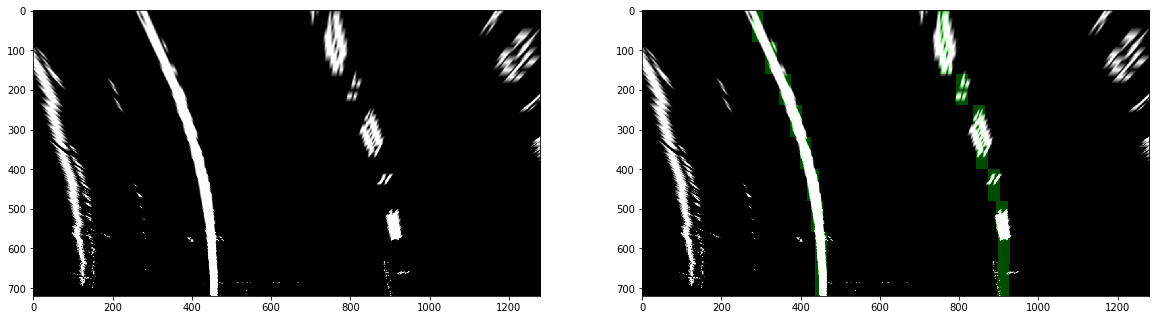

In [8]:
# ############### Find lane line in transformed images ##############################################
#detect lane lines in the transformed images
win_width = 30
win_height = 80 # break image into 9 vertical layers since the height of the image is 720
margin = 100 # Slice area for searching
left_centers = []
right_centers = []
center_tracker = tracker(window_width=win_width, window_height=win_height, margin=margin, ym2pixel=10/720, xm2pixel=4/384, smooth_factor=15)
centers = center_tracker.find_window_centroids(warped)


if len(centers) > 0:
	l_points = np.zeros_like(warped)
	r_points = np.zeros_like(warped)

	for level in range(int(warped.shape[0]/win_height)):
		# append right and left center points from bottom to top
		left_centers.append(centers[level][0])
		right_centers.append(centers[level][1])
		# find the mask window for lane lane in  each level
		l_mask = window_mask(win_width, win_height, warped, centers[level][0], level)
		r_mask = window_mask(win_width, win_height, warped, centers[level][1], level)
		l_points[(l_points==255)|(l_mask==1)] = 255
		r_points[(r_points==255)|(r_mask==1)] = 255
 
	mask = np.array(l_points + r_points, np.uint8)
	zero_channel = np.zeros_like(warped, np.uint8)

	# when using cv2.merge, ensure each channel to be the same dtype.
	mask = np.array(cv2.merge((zero_channel, mask, zero_channel)), np.uint8)
	warped_1 = np.array(cv2.merge((warped, warped, warped)), np.uint8)
	lane_marker = cv2.addWeighted(warped_1, 1, mask, 0.3, 0)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(warped,cmap='gray')
ax2.imshow(lane_marker)
plt.show()

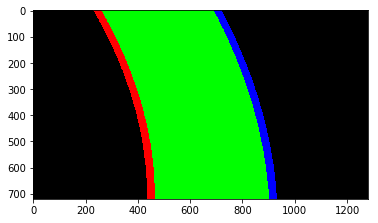

In [9]:
################# find the coefficients of the detected curve and draw them ##########################
# Find center points according to left/right center array, since this only provide x coordinate of the center
# y coordinate is the bottom y in each level
y_centers = range(warped.shape[0], 0, -win_height)
y_values = range(0, warped.shape[0])

left_fit = np.polyfit(y_centers, left_centers, 2)
right_fit = np.polyfit(y_centers, right_centers, 2)
left_fitx = left_fit[0]*y_values*y_values + left_fit[1]*y_values + left_fit[2]
right_fitx = right_fit[0]*y_values*y_values + right_fit[1]*y_values + right_fit[2]

left_pts = np.array(list(zip(np.concatenate((left_fitx-win_width/2, left_fitx[::-1]+win_width/2)), np.concatenate((y_values, y_values[::-1])) )), np.int32)
right_pts = np.array(list(zip(np.concatenate((right_fitx-win_width/2, right_fitx[::-1]+win_width/2)), np.concatenate((y_values, y_values[::-1])) )), np.int32)
middle_pts = np.array(list(zip(np.concatenate((left_fitx+win_width/2, right_fitx[::-1]-win_width/2)), np.concatenate((y_values, y_values[::-1])) )), np.int32) 	

lane = np.zeros_like(img)
road_bkg = np.zeros_like(img)
cv2.fillPoly(lane, [left_pts], color=[255,0,0])
cv2.fillPoly(lane, [right_pts], color=[0,0,255])
cv2.fillPoly(lane, [middle_pts], color=[0,255,0])
plt.imshow(lane)
plt.show()

683.915250355


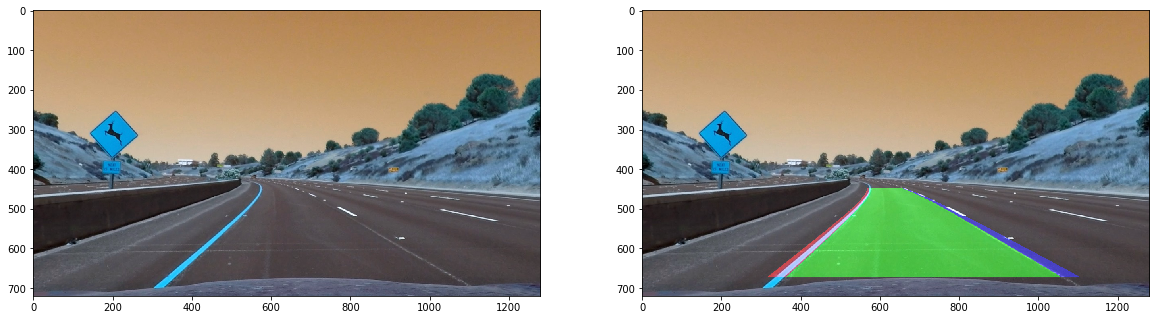

In [10]:
lane_warped = cv2.warpPerspective(lane, Minv, img_size, flags=cv2.INTER_LINEAR)

# calculate the curvature of current road
xm_per_pixel = center_tracker.xm_per_pixel
ym_per_pixel = center_tracker.ym_per_pixel
curv_fit = np.polyfit(np.array(y_centers, np.float32)*ym_per_pixel, np.array(left_centers, np.float32)*xm_per_pixel, 2)
curv_rad = ((1 + (2*curv_fit[0]*y_values[-1]*ym_per_pixel*curv_fit[1])**2)**(3/2))/np.absolute(2*curv_fit[0])
# calcutate the distance from center
lane_center = (left_fitx[-1] + right_fitx[-1])/2
print(lane_center)
diff = (lane_center - img_size[0]/2)*xm_per_pixel
if diff <= 0:
	dire = 'right'
else:
	dire = 'left'

result = cv2.addWeighted(img, 1.0, lane_warped, 0.5, 0.0)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax2.imshow(result)
plt.show()

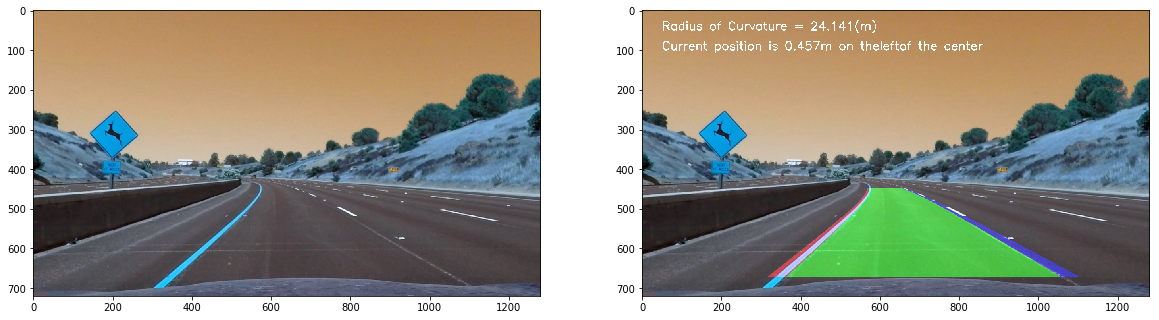

In [11]:
# write curvature and position information onto the images
cv2.putText(result, "Radius of Curvature = " + str(round(curv_rad, 3)) + '(m)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
cv2.putText(result, "Current position is " + str(round(diff,3)) + 'm on the' + dire + "of the center", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax2.imshow(result)
plt.show()